In [1]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scanpy.tools._utils import get_init_pos_from_paga 
from sklearn.metrics import mean_squared_error

import rmm
import cupy
import cudf
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

from cuml.manifold import UMAP
from cuml.decomposition import TruncatedSVD

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

/nfs/turbo/umms-indikar/Cooper/conda_envs/rapids/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 271 ms, sys: 3.25 s, total: 3.52 s
Wall time: 6.78 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

# Recompute PCA on Imputed Embeddings

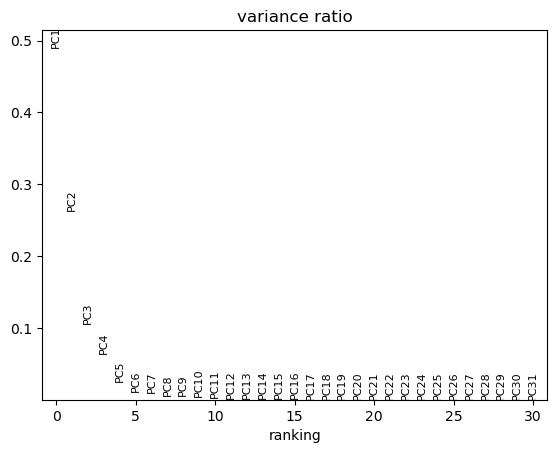

CPU times: user 486 ms, sys: 287 ms, total: 773 ms
Wall time: 844 ms


In [3]:
%%time
rsc.get.anndata_to_GPU(adata)
rsc.pp.pca(adata, layer='scvi')

sc.pl.pca_variance_ratio(adata)

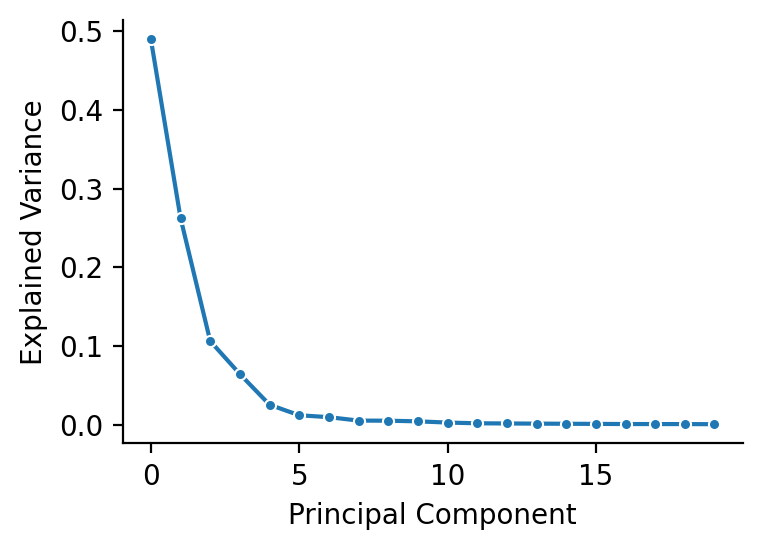

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.75

n = 20

sns.lineplot(
    adata.uns['pca']['variance_ratio'][:n],
    marker="o",
    markersize=4,
)

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
sns.despine()

# Scree Plot

🔹 Using 50 components...
🔹 Loading data onto GPU...
   Matrix shape: (6895, 15906), dtype=float32

🔹 Initializing Truncated SVD (k=35)...
🔹 Fitting SVD model and transforming data...
   Latent representation shape (Z): (6895, 50)
   Components shape (VT): (50, 15906)
   Singular values (length 50):


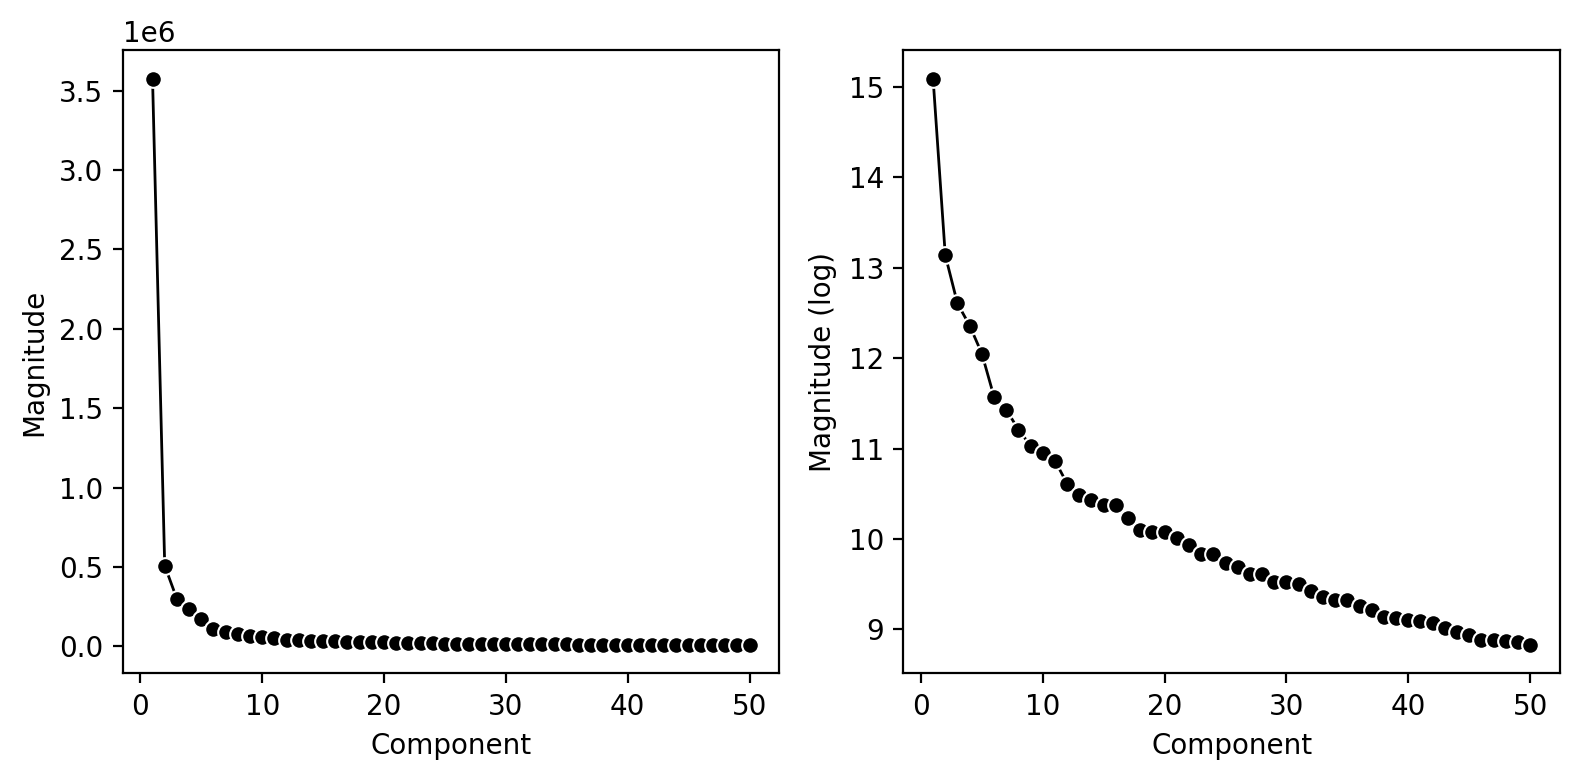

CPU times: user 5.5 s, sys: 4.61 s, total: 10.1 s
Wall time: 10.1 s


In [16]:
%%time 
components = 50
print(f"🔹 Using {components} components...")
print("🔹 Loading data onto GPU...")
X = cp.asarray(adata.layers['scvi'], dtype=cp.float32)
print(f"   Matrix shape: {X.shape}, dtype={X.dtype}")

print("\n🔹 Initializing Truncated SVD (k=35)...")
svd = TruncatedSVD(
    n_components=components,
    n_iter=7,
    random_state=0,
)

print("🔹 Fitting SVD model and transforming data...")
Z = svd.fit_transform(X)
print(f"   Latent representation shape (Z): {Z.shape}")

VT = svd.components_
print(f"   Components shape (VT): {VT.shape}")

S = svd.singular_values_
print(f"   Singular values (length {len(S)}):")

# Ensure singular values are NumPy
S_cpu = cp.asnumpy(S)

df = pd.DataFrame({
    "Component": range(1, len(S_cpu) + 1),
    "SingularValue": S_cpu,
    "SingularValue_log": np.log(S_cpu)
})

# Two-column subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharex=True)

sns.lineplot(data=df, x="Component", y="SingularValue",
             lw=1, marker="o", color="k", ax=axes[0])
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Magnitude")

sns.lineplot(data=df, x="Component", y="SingularValue_log",
             lw=1, marker="o", color="k", ax=axes[1])
axes[1].set_xlabel("Component")
axes[1].set_ylabel("Magnitude (log)")

plt.tight_layout()
plt.show()


In [7]:
%%time
def pca_reconstruction_error(adata, n_pcs=None):
    """
    Compute PCA reconstruction error on GPU.
    
    Parameters
    ----------
    adata : AnnData
        Object with PCA already computed (adata.obsm["X_pca"], adata.varm["PCs"]).
    n_pcs : int or None
        Number of PCs to use for reconstruction. If None, use all available.
    
    Returns
    -------
    mse : float
        Mean squared reconstruction error.
    rel_err : float
        Relative Frobenius norm error.
    """
    # Original matrix
    X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    X_gpu = cp.asarray(X)

    # PCA embedding and loadings
    X_pca_gpu = cp.asarray(adata.obsm["X_pca"])
    PCs_gpu   = cp.asarray(adata.varm["PCs"])

    # Select subset of PCs if requested
    if n_pcs is not None:
        X_pca_gpu = X_pca_gpu[:, :n_pcs]
        PCs_gpu   = PCs_gpu[:, :n_pcs]

    # Reconstruction
    X_rec_gpu = X_pca_gpu @ PCs_gpu.T

    # Errors
    diff = X_gpu - X_rec_gpu
    mse = float(cp.mean(diff**2).get())
    rel_err = float((cp.linalg.norm(diff, "fro") / cp.linalg.norm(X_gpu, "fro")).get())

    return mse, rel_err

mse_all, rel_all = pca_reconstruction_error(adata)
print("MSE:", mse_all)
print("Relative error:", rel_all)

MSE: 761.5779241610928
Relative error: 4.356772268535843
CPU times: user 979 ms, sys: 130 ms, total: 1.11 s
Wall time: 1.12 s


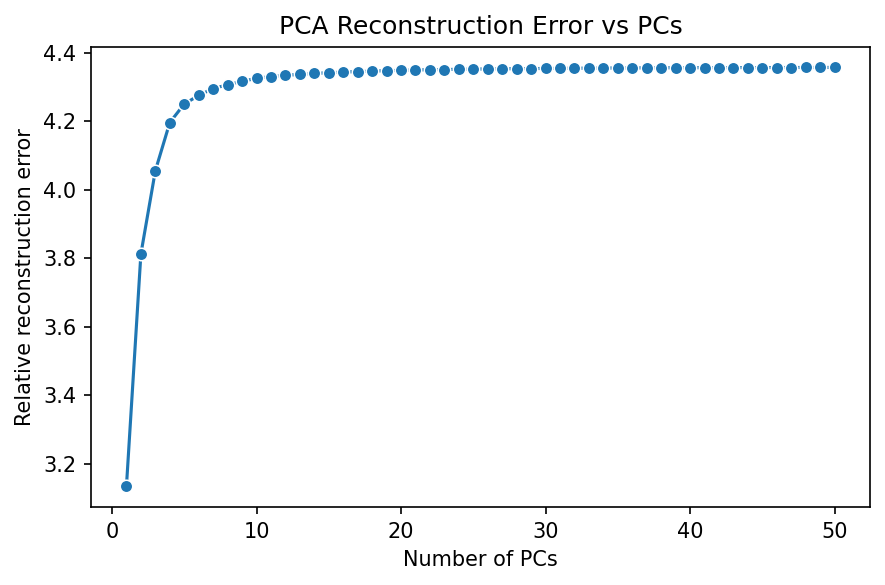

CPU times: user 49.6 s, sys: 4.39 s, total: 54 s
Wall time: 54.1 s


In [8]:
%%time 

errors = []
max_pcs = adata.obsm["X_pca"].shape[1]

for k in range(1, max_pcs + 1):
    mse, rel = pca_reconstruction_error(adata, n_pcs=k)
    errors.append({"n_pcs": k, "mse": mse, "rel_error": rel})

df = pd.DataFrame(errors)

plt.figure(figsize=(6,4), dpi=150)
sns.lineplot(data=df, x="n_pcs", y="rel_error", marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Relative reconstruction error")
plt.title("PCA Reconstruction Error vs PCs")
plt.tight_layout()
plt.show()

# UMAP

In [9]:
# %%time
# # 1) Get data to GPU (assumes adata.X already normalized/scaled)
# Xg = cp.asarray(adata.obsm['X_pca'])

# # 2) Learn UMAP projection on GPU
# umap = UMAP(
#     n_neighbors=25,
#     min_dist=1.0,
#     n_components=2,
#     metric="euclidean",      # e.g., "cosine"
#     random_state=1729,
#     output_type="cupy",
# )
# X_umap = umap.fit_transform(Xg)    # (cells × 2) on GPU
# print(f"{X_umap.shape=}")

# # 4) Store back to AnnData (host copy)
# adata.obsm["X_umap"] = cp.asnumpy(X_umap)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3

# palette = {
#     "G1": "#D73027",        
#     "S": "#FDAE61",       
#     "G2M": "#1A9850",    
# }
    
# sc.pl.umap(
#     adata,
#     color='cluster_phase',
#     size=25,
#     ncols=3,
#     alpha=1,
#     use_raw=False,
#     add_outline=True,
#     outline_color=('k', 'k'),
#     palette=palette,
#     title='Phase',
#     frameon=False,
#     wspace=0.25,
# )

# Add new sample labels

sample_labels
5    862
1    862
7    862
2    862
0    862
6    862
3    862
4    861


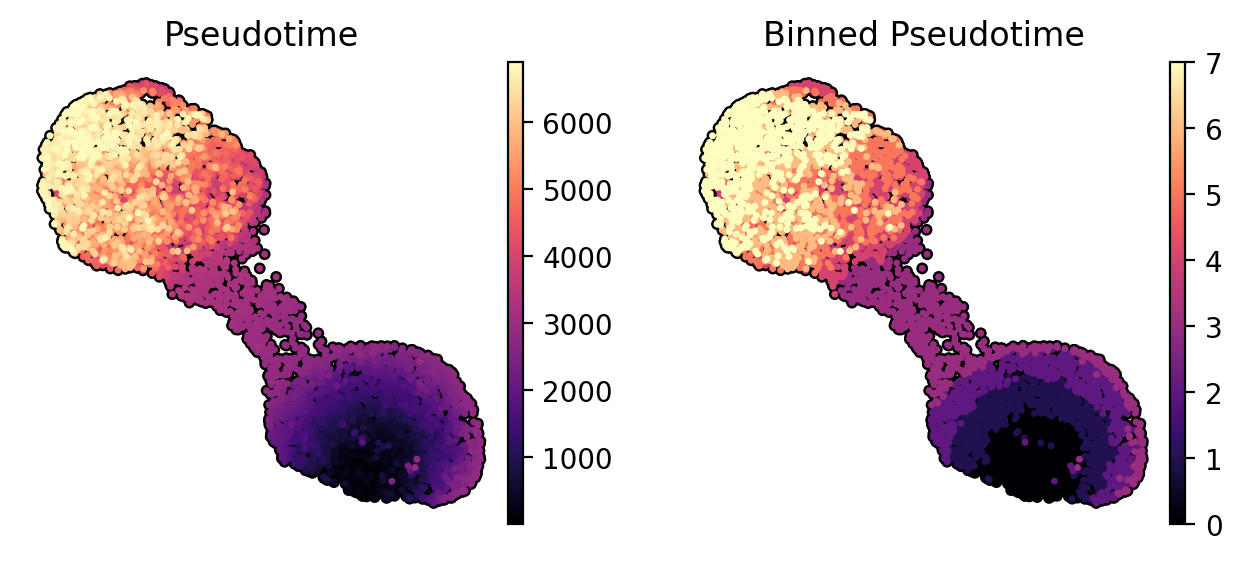

In [10]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

n = 8  # number of bins

adata.obs['sample_labels'] = pd.cut(
    adata.obs['global_ordering'],
    bins=n,
    labels=range(n)
).astype(int)

print(adata.obs['sample_labels'].value_counts().to_string())
    
sc.pl.umap(
    adata,
    color=['global_ordering', 'sample_labels'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    cmap='magma',
    title=['Pseudotime', 'Binned Pseudotime'],
    frameon=False,
    wspace=0.25,
)

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Write out

In [ ]:
# %%time
# outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/TrajNet_input.h5ad"

# # add a layer for "velocity_pca"
# adata.obsm['velocity_pca'] = adata.obsm['X_pca'].copy()

# adata.write(outpath)
# adata